In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from IPython.display import clear_output

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

algorithm_globals.random_seed = 42

In [3]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [4]:
#circuit 01
circuit01 = QuantumCircuit(3)

#Input layer
circuit01.ry(Parameter('i_3'),2)
circuit01.ry(Parameter('i_1'),0)
circuit01.ry(Parameter('i_2'),1)

#mixing/training layer, can very different. comparable to classical setup of NN, i.e. LSTM, hidden layers, activation functions. Still unclear which is good and what works best
circuit01.rx(Parameter('w_1'),0)
circuit01.crz(Parameter('w_12'),0,1)
circuit01.rx(Parameter('w_2'),1)
circuit01.crz(Parameter('w_23'),1,2)
circuit01.rx(Parameter('w_3'),2)
circuit01.crz(Parameter('w_13'),2,0)

circuit01.draw()

┌─────────┐┌─────────┐                                              »
q_0: ┤ Ry(i_1) ├┤ Rx(w_1) ├─────■────────────────────────────────────────»
     ├─────────┤└─────────┘┌────┴─────┐┌─────────┐                       »
q_1: ┤ Ry(i_2) ├───────────┤ Rz(w_12) ├┤ Rx(w_2) ├─────■─────────────────»
     ├─────────┤           └──────────┘└─────────┘┌────┴─────┐┌─────────┐»
q_2: ┤ Ry(i_3) ├──────────────────────────────────┤ Rz(w_23) ├┤ Rx(w_3) ├»
     └─────────┘                                  └──────────┘└─────────┘»
«     ┌──────────┐
«q_0: ┤ Rz(w_13) ├
«     └────┬─────┘
«q_1: ─────┼──────
«          │      
«q_2: ─────■──────
«

In [5]:
#circuit 02
circuit02 = QuantumCircuit(4)

#Input layer
circuit02.ry(Parameter('i_1'),0)
circuit02.ry(Parameter('i_2'),1)
circuit02.ry(Parameter('i_3'),2)
circuit02.ry(Parameter('i_4'),3)

#mixing/training layer, can very different. comparable to classical setup of NN, i.e. LSTM, hidden layers, activation functions. Still unclear which is good and what works best
circuit02.rx(Parameter('w_1'),0)
circuit02.rx(Parameter('w_2'),1)
circuit02.rx(Parameter('w_3'),2)
circuit02.rx(Parameter('w_4'),3)
circuit02.crz(Parameter('w_12'),0,1)
circuit02.crz(Parameter('w_23'),1,2)
circuit02.crz(Parameter('w_34'),2,3)
circuit02.crz(Parameter('w_13'),3,0)

circuit02.draw()

┌─────────┐┌─────────┐                                    ┌──────────┐
q_0: ┤ Ry(i_1) ├┤ Rx(w_1) ├─────■──────────────────────────────┤ Rz(w_13) ├
     ├─────────┤├─────────┤┌────┴─────┐                        └────┬─────┘
q_1: ┤ Ry(i_2) ├┤ Rx(w_2) ├┤ Rz(w_12) ├─────■───────────────────────┼──────
     ├─────────┤├─────────┤└──────────┘┌────┴─────┐                 │      
q_2: ┤ Ry(i_3) ├┤ Rx(w_3) ├────────────┤ Rz(w_23) ├─────■───────────┼──────
     ├─────────┤├─────────┤            └──────────┘┌────┴─────┐     │      
q_3: ┤ Ry(i_4) ├┤ Rx(w_4) ├────────────────────────┤ Rz(w_34) ├─────■──────
     └─────────┘└─────────┘                        └──────────┘

In [6]:
#circuit 03
circuit03 = QuantumCircuit(4)

#Input layer
circuit03.ry(Parameter('i_1'),0)
circuit03.ry(Parameter('i_2'),1)
circuit03.ry(Parameter('i_3'),2)
circuit03.ry(Parameter('i_4'),3)

#mixing/training layer, can very different. comparable to classical setup of NN, i.e. LSTM, hidden layers, activation functions. Still unclear which is good and what works best
circuit03.rx(Parameter('w_x1'),0)
circuit03.rx(Parameter('w_x2'),1)
circuit03.rx(Parameter('w_x3'),2)
circuit03.rx(Parameter('w_x4'),3)

circuit03.ry(Parameter('w_y1'),0)
circuit03.ry(Parameter('w_y2'),1)
circuit03.ry(Parameter('w_y3'),2)
circuit03.ry(Parameter('w_y4'),3)

circuit03.rz(Parameter('w_z1'),0)
circuit03.rz(Parameter('w_z2'),1)
circuit03.rz(Parameter('w_z3'),2)
circuit03.rz(Parameter('w_z4'),3)

circuit03.draw()

┌─────────┐┌──────────┐┌──────────┐┌──────────┐
q_0: ┤ Ry(i_1) ├┤ Rx(w_x1) ├┤ Ry(w_y1) ├┤ Rz(w_z1) ├
     ├─────────┤├──────────┤├──────────┤├──────────┤
q_1: ┤ Ry(i_2) ├┤ Rx(w_x2) ├┤ Ry(w_y2) ├┤ Rz(w_z2) ├
     ├─────────┤├──────────┤├──────────┤├──────────┤
q_2: ┤ Ry(i_3) ├┤ Rx(w_x3) ├┤ Ry(w_y3) ├┤ Rz(w_z3) ├
     ├─────────┤├──────────┤├──────────┤├──────────┤
q_3: ┤ Ry(i_4) ├┤ Rx(w_x4) ├┤ Ry(w_y4) ├┤ Rz(w_z4) ├
     └─────────┘└──────────┘└──────────┘└──────────┘

Loading the adhoc data with size 100

In [7]:
df = pd.read_csv('datasets/vlds_100.csv', index_col=[0])
df.head()

,feature_1,feature_2,label
0,7.0,37.0,1.0
1,27.0,17.0,0.0
2,5.0,40.0,1.0
3,13.0,43.0,1.0
4,5.0,44.0,1.0


In [8]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration,  vlds with datasize = 100")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

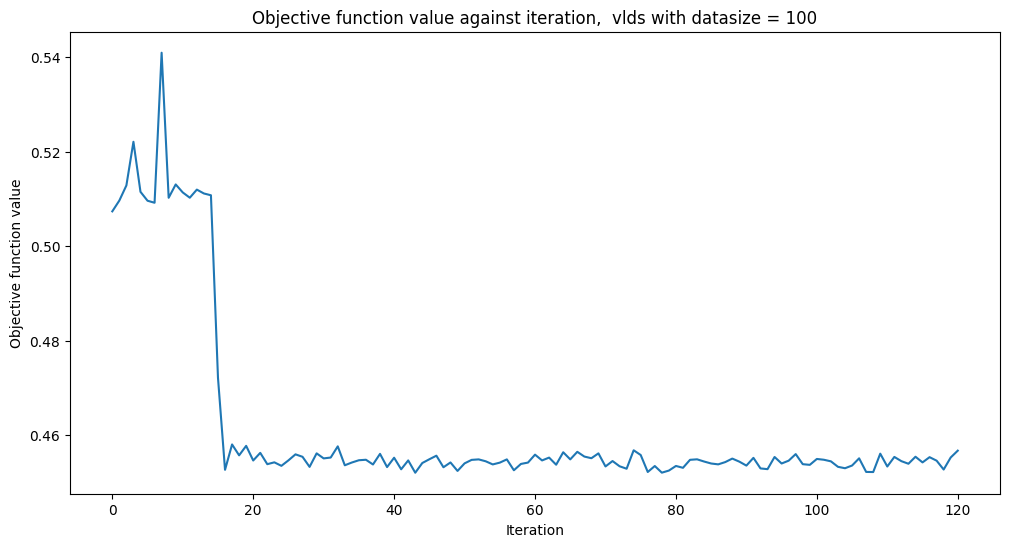

100%|██████████| 10/10 [21:18<00:00, 127.89s/it]

Score of circuit 1:  [0.36 0.52 0.4  0.32 0.6  0.4  0.52 0.48 0.4  0.48]
Score of circuit 2:  [0.36 0.52 0.44 0.32 0.56 0.36 0.52 0.48 0.4  0.52]
Score of circuit 3:  [0.36 0.48 0.4  0.44 0.36 0.4  0.48 0.28 0.4  0.4 ]
Median of circuit01:  0.44
Median of circuit02:  0.45999999999999996
Median of circuit03:  0.4


In [9]:
datasize = 100
output_shape = 2
cirtui1_score = []
cirtui2_score = []
cirtui3_score = []


for x in tqdm(range(10)):     
     
    # ======== setup data ========

    features = df.iloc[0:datasize, 0:2].values
    labels = df.iloc[0:datasize, 2:3].values.flatten()

    features, features_test, labels, labels_test = train_test_split(features, labels, test_size=0.25, random_state=x)  

    def parity(x):
        return x%2
    
    # ======== circuit 1 ========

    circuit1_qnn = CircuitQNN(circuit=circuit01,    
                         input_params=circuit01.parameters[0:2],
                         weight_params=circuit01.parameters[2:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    circuit1_classifier= NeuralNetworkClassifier(neural_network=circuit1_qnn,                                             
                            optimizer=COBYLA(),
                            callback=callback_graph)
    
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    circuit1_classifier.fit(features, labels)

    plt.rcParams["figure.figsize"] = (6, 3)

    cirtui1_score = np.append(cirtui1_score, circuit1_classifier.score(features_test, labels_test))
    
    # ======== circuit 2 ========

    circuit2_qnn = CircuitQNN(circuit=circuit02,    
                         input_params=circuit02.parameters[0:2],
                         weight_params=circuit02.parameters[2:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    circuit2_classifier= NeuralNetworkClassifier(neural_network=circuit2_qnn,                                             
                            optimizer=COBYLA(),
                            callback=callback_graph)
    
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    circuit2_classifier.fit(features, labels)

    plt.rcParams["figure.figsize"] = (6, 3)

    cirtui2_score = np.append(cirtui2_score, circuit2_classifier.score(features_test, labels_test))
    
    # ======== circuit 3 ========

    circuit3_qnn = CircuitQNN(circuit=circuit03,    
                         input_params=circuit03.parameters[0:2],
                         weight_params=circuit03.parameters[2:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    circuit3_classifier= NeuralNetworkClassifier(neural_network=circuit3_qnn,                                             
                            optimizer=COBYLA(),
                            callback=callback_graph)
    
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    circuit3_classifier.fit(features, labels)

    plt.rcParams["figure.figsize"] = (6, 3)

    cirtui3_score = np.append(cirtui3_score, circuit3_classifier.score(features_test, labels_test))
print('Score of circuit 1: ',cirtui1_score)
print('Score of circuit 2: ',cirtui2_score)
print('Score of circuit 3: ',cirtui3_score)

import statistics
print("Median of circuit01: ", str(statistics.median(cirtui1_score)))
print("Median of circuit02: ", str(statistics.median(cirtui2_score)))
print("Median of circuit03: ", str(statistics.median(cirtui3_score)))

In [10]:
"""
100%|██████████| 10/10 [21:18<00:00, 127.89s/it]
Score of circuit 1:  [0.36 0.52 0.4  0.32 0.6  0.4  0.52 0.48 0.4  0.48]
Score of circuit 2:  [0.36 0.52 0.44 0.32 0.56 0.36 0.52 0.48 0.4  0.52]
Score of circuit 3:  [0.36 0.48 0.4  0.44 0.36 0.4  0.48 0.28 0.4  0.4 ]
Median of circuit01:  0.44
Median of circuit02:  0.45999999999999996
Median of circuit03:  0.4
"""

'\n\n'

{'whiskers': [<matplotlib.lines.Line2D at 0x1be0b418880>,
 'caps': [<matplotlib.lines.Line2D at 0x1be0b418dc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1be0b3cf4c0>,
 'medians': [<matplotlib.lines.Line2D at 0x1be0b419300>,
 'fliers': [<matplotlib.lines.Line2D at 0x1be0b4195a0>,
 'means': []}

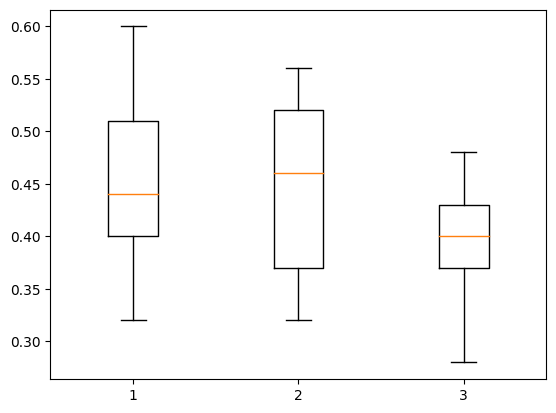

In [2]:
cirtui1_score = [ 0.36, 0.52, 0.4, 0.32, 0.6, 0.4, 0.52, 0.48, 0.4, 0.48 ]
cirtui2_score = [ 0.36, 0.52, 0.44, 0.32, 0.56, 0.36, 0.52, 0.48, 0.4, 0.52 ]
cirtui3_score = [ 0.36, 0.48, 0.4, 0.44, 0.36, 0.4, 0.48, 0.28, 0.4, 0.4 ]

scores = [cirtui1_score, cirtui2_score, cirtui3_score]

plt.boxplot(scores)